In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import cPickle as pickle
from spiketopics.helpers import *

%matplotlib inline
sns.set_style('darkgrid')

# Load in data

In [2]:
infile = 'data/fitted_model_object.pkl'
gpm = pickle.load(open(infile, 'rb'))
dt = 0.020

In [3]:
gpm.Nframe.head()

,unit,time,count,lam0,lam1
0,0,0,0,-0.330602,-0.309942
1,0,0,0,-0.330602,-0.309942
2,0,0,1,-0.385702,-0.427034
3,0,0,0,-0.330602,-0.309942
4,0,0,1,-0.385702,-0.427034


In [4]:
if gpm.regressors:
    gpm.Xframe.head()

# Plot inferred categories as matrix

In [5]:
xi = gpm.nodes['HMM'].nodes['z'].z[1].copy()
T, K = xi.shape
print xi.shape

(624, 10)


In [6]:
# flip regressors so they are mostly 0
#for col in xrange(xi.shape[1]):
#    if np.mean(xi[:, col]) > 0.5:
#        xi[:, col] = 1 - xi[:, col]

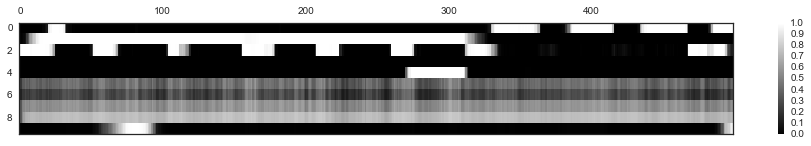

In [7]:
matshow(xi[:500].T, vmin=0, vmax=1);
plt.colorbar();

## Make $\xi$ dataframe:

In [8]:
xif = pd.DataFrame(xi)
xif.columns = ['Z' + str(k) for k in range(K)]
xif.index.name = 'time'
xif = xif.reset_index()

# Posteriors for effects

## Baselines

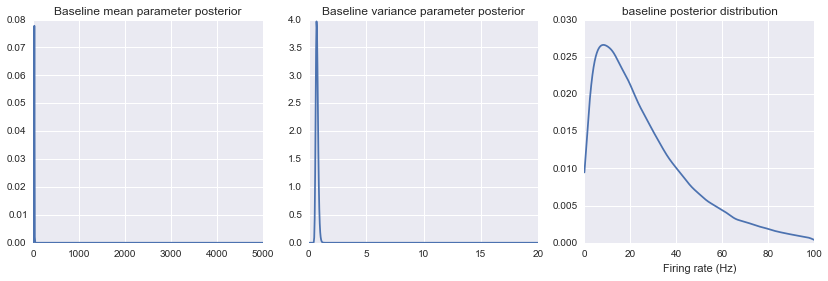

In [9]:
plt.figure(figsize=(14, 4))

th = gpm.nodes['baseline_mean']
cc = gpm.nodes['baseline_shape']
th_pars = [th.post_shape, th.post_rate]
cc_pars = [cc.post_shape, cc.post_rate]
samples = gamma_from_hypers(th_pars, cc_pars, 1e5)

plt.subplot(1, 3, 1)
xx = np.linspace(0, 5000, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0], scale=th_pars[1]/dt))
plt.title('Baseline mean parameter posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 20, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0], scale=cc_pars[1]))
plt.title('Baseline variance parameter posterior');

plt.subplot(1, 3, 3)
sns.kdeplot(samples / dt, gridsize=1e4, clip=(0, 100))
plt.title('baseline posterior distribution')
plt.xlabel('Firing rate (Hz)')
plt.xlim(0, 100);

## Regressors

In [10]:
if gpm.regressors:
    plt.figure(figsize=(8, 6));
    inferred_means = gpm.nodes['fr_regressors'].expected_x()
    R = inferred_means.shape[1]
    for r in xrange(R):
        plt.hist(inferred_means[:, r], bins=50, normed=True, alpha=0.25, label='X' + str(r))
    plt.title('Regression effects');
    plt.legend()
    plt.ylim(0, 5);
    plt.xlim(0, 5);

## Latent Categories

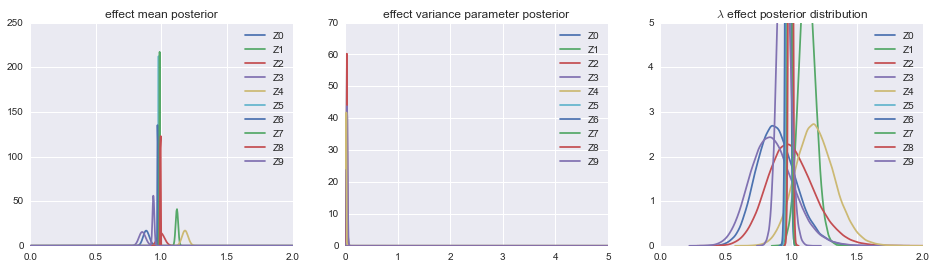

In [11]:
plt.figure(figsize=(16, 4))

th = gpm.nodes['fr_latents_mean']
cc = gpm.nodes['fr_latents_shape']

th_pars = np.c_[th.post_shape, th.post_rate].T
cc_pars = np.c_[cc.post_shape, cc.post_rate].T

plt.subplot(1, 3, 1)
xx = np.linspace(0, 2, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0, kk], scale=th_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect mean posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 5, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0, kk], scale=cc_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect variance parameter posterior');

plt.subplot(1, 3, 3)
for kk in xrange(K):
    samples = gamma_from_hypers(th_pars[:, kk], cc_pars[:, kk], 1e5)
    sns.kdeplot(samples, gridsize=1e4, clip=(0, 10), label='Z' + str(kk))
plt.legend()
plt.title(r'$\lambda$ effect posterior distribution')
plt.xlim(0, 2);
plt.ylim(0, 5);

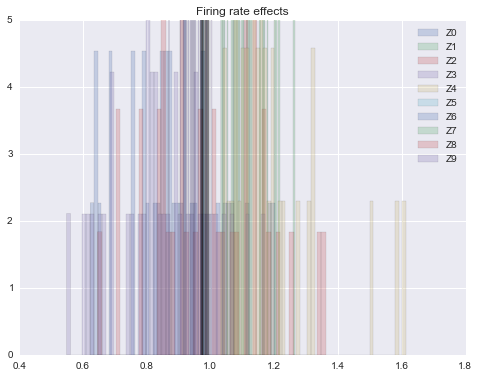

In [12]:
plt.figure(figsize=(8, 6))

inferred_effects = gpm.nodes['fr_latents'].expected_x()
for kk in xrange(K):
    plt.hist(inferred_effects[..., kk], bins=50, normed=True, alpha=0.25, label='Z' + str(kk));
plt.legend();
plt.title('Firing rate effects');
plt.ylim(0, 5);

## Overdispersion

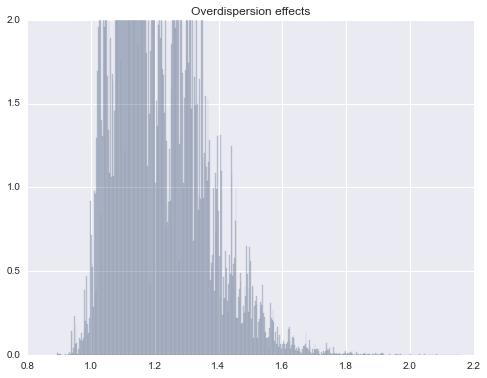

In [13]:
if gpm.overdispersion:
    plt.figure(figsize=(8, 6))

    inferred_means = gpm.nodes['overdispersion'].expected_x().ravel()
    plt.hist(inferred_means, bins=500, normed=True, alpha=0.25);
    plt.title('Overdispersion effects');
    plt.ylim(0, 2);

# Load and prepare coded features:

Our goal here is to load the ethogram, join it to the inferred ethogram, and perform some comparisons to see if any of our discovered categories match hand-labeled categories from the ethogram.

In [14]:
codefile = 'data/roitman_fd_data.csv'
code = pd.read_csv(codefile).groupby('utime').max().reset_index()

In [15]:
code.head()

,utime,count,trial,coherence,fixation_on,fixation,target_on,stim_on,stim_off,fixation_off,...,unit,Xstim,Xcoh0,Xcoh32,Xcoh64,Xcoh128,Xcoh256,Xcoh512,Xinto,Xout
0,0,3,69,0,0,467,1026,1234,2282,3654,...,626,False,False,False,False,False,False,False,False,False
1,1,4,69,0,0,467,1026,1234,2282,3654,...,626,True,True,False,False,False,False,False,True,False
2,2,5,69,0,0,467,1026,1234,2282,3654,...,626,True,True,False,False,False,False,False,True,False
3,3,4,69,0,0,467,1026,1234,2282,3654,...,626,True,True,False,False,False,False,False,True,False
4,4,4,69,0,0,467,1026,1234,2282,3654,...,626,True,True,False,False,False,False,False,True,False


In [16]:
# convert bools to floats
for col in code:
    code[col] = code[col].astype('float')

In [17]:
# merge labeled and inferred etho on movie and frame columns
edf = pd.merge(code, xif, how='right', left_on='utime', right_on='time')
edf.columns

Index([u'utime', u'count', u'trial', u'coherence', u'fixation_on', u'fixation', u'target_on', u'stim_on', u'stim_off', u'fixation_off', u'saccade', u'reward', u'choice', u'correct', u'unit', u'Xstim', u'Xcoh0', u'Xcoh32', u'Xcoh64', u'Xcoh128', u'Xcoh256', u'Xcoh512', u'Xinto', u'Xout', u'time', u'Z0', u'Z1', u'Z2', u'Z3', u'Z4', u'Z5', u'Z6', u'Z7', u'Z8', u'Z9'], dtype='object')

In [18]:
# get rid of categories that are either identifiers or have non-binary entries
to_drop = [col for col in edf.columns if not ('Z' in col or 'X' in col)]
edf = edf.drop(to_drop, axis=1)

In [19]:
edf.head()

,Xstim,Xcoh0,Xcoh32,Xcoh64,Xcoh128,Xcoh256,Xcoh512,Xinto,Xout,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9
0,0,0,0,0,0,0,0,0,0,0.000317,0.008500,0.916539,2.127640e-04,0.000043,0.043482,0.043514,0.041877,0.039544,0.005357
1,1,1,0,0,0,0,0,1,0,0.000043,0.015053,0.992676,2.591838e-06,0.000042,0.224006,0.132962,0.344569,0.349573,0.002221
2,1,1,0,0,0,0,0,1,0,0.000250,0.020277,0.998010,1.418449e-05,0.000005,0.354225,0.222341,0.501415,0.537119,0.001951
3,1,1,0,0,0,0,0,1,0,0.000005,0.038064,0.999969,4.567693e-08,0.000018,0.358846,0.221673,0.522339,0.621438,0.001659
4,1,1,0,0,0,0,0,1,0,0.000125,0.077397,0.999640,1.585686e-06,0.000006,0.412957,0.267347,0.568470,0.680596,0.002030


# View results:

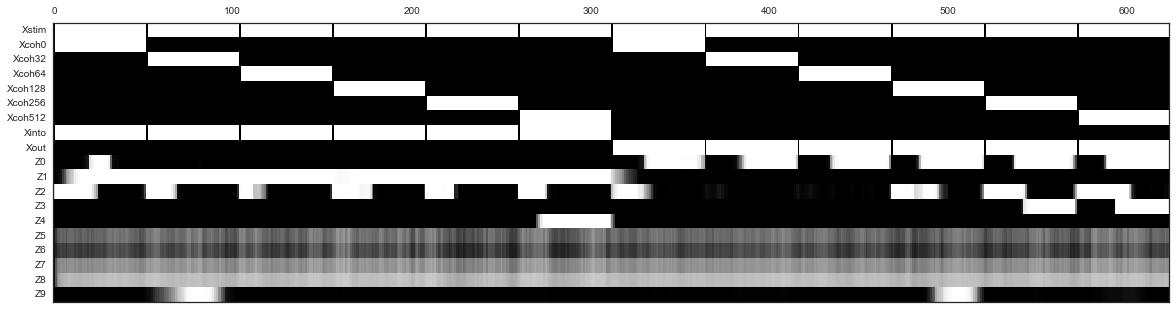

In [20]:
# plot a section in time; each row is a regressor; bottom rows are inferred categories
trng = slice(None)
matshow(edf.iloc[trng].values.T, vmin=0, vmax=1);
col_labels = edf.columns
plt.yticks(xrange(len(col_labels)), col_labels);
plt.gcf().set_size_inches([20, 5])

## Overlap analysis:

Define the overlap as the maximum of the match or mismatch percentage. That is, if $x$ and $y$ are binary vectors, 
$$
\mathrm{overlap} = \max \{ \mathbb{E}[xy + (1-x)(1-y)], \mathbb{E}[(1-x)y + x(1-y)]\}
$$

In [21]:
match = (edf.T.dot(edf) + (1 - edf.T).dot(1 - edf)) / T
mismatch = (edf.T.dot(1 - edf) + (1 - edf.T).dot(edf)) / T
overlap = np.maximum(match, mismatch)

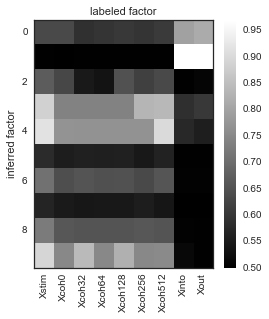

In [22]:
row_labels = edf.columns[:-K]
matshow(overlap.values[-K:,:-K]) #, vmin=0.5, vmax=1)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');

In [23]:
overlap.iloc[-K:, :]

,Xstim,Xcoh0,Xcoh32,Xcoh64,Xcoh128,Xcoh256,Xcoh512,Xinto,Xout,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9
Z0,0.635100,0.636123,0.591476,0.596095,0.605826,0.598869,0.606660,0.796146,0.815076,0.980066,0.802897,0.555522,0.747658,0.587474,0.532247,0.574283,0.516908,0.568532,0.646372
Z1,0.502285,0.501551,0.502730,0.502722,0.502140,0.502760,0.502631,0.970197,0.969739,0.802897,0.984861,0.503706,0.594065,0.568710,0.502718,0.503778,0.501819,0.501418,0.509543
Z2,0.669581,0.631630,0.547206,0.535154,0.648905,0.619186,0.636812,0.501856,0.510030,0.555522,0.503706,0.960201,0.598302,0.608954,0.528323,0.572193,0.521725,0.577156,0.601466
Z3,0.883917,0.739696,0.739699,0.739687,0.739691,0.834139,0.838903,0.587229,0.606459,0.747658,0.594065,0.598302,0.998110,0.836436,0.569759,0.679250,0.554276,0.687822,0.819298
Z4,0.915736,0.770798,0.769812,0.769804,0.769836,0.769821,0.900481,0.573565,0.556043,0.587474,0.568710,0.608954,0.836436,0.996036,0.573255,0.690944,0.559349,0.702637,0.846567
Z5,0.579601,0.553493,0.562272,0.558366,0.559740,0.545063,0.564186,0.502246,0.502697,0.532247,0.502718,0.528323,0.569759,0.573255,0.523797,0.547424,0.505132,0.535304,0.574261
Z6,0.710267,0.643698,0.654545,0.648692,0.651644,0.634620,0.656692,0.505313,0.504452,0.574283,0.503778,0.572193,0.679250,0.690944,0.547424,0.608084,0.523464,0.598731,0.686943
Z7,0.567950,0.548504,0.542715,0.544755,0.544391,0.553303,0.541442,0.500657,0.500005,0.516908,0.501819,0.521725,0.554276,0.559349,0.505132,0.523464,0.514133,0.535626,0.553798
Z8,0.727250,0.660405,0.655345,0.655343,0.655943,0.661363,0.654378,0.504571,0.502185,0.568532,0.501418,0.577156,0.687822,0.702637,0.535304,0.598731,0.535626,0.612969,0.691803
Z9,0.893983,0.750437,0.842874,0.749868,0.824094,0.750028,0.753726,0.516286,0.502733,0.646372,0.509543,0.601466,0.819298,0.846567,0.574261,0.686943,0.553798,0.691803,0.963966


Try using the MPM (maximizer of posterior marginals) rather than the posterior:

In [24]:
# round to 0 or 1 elementwise
medf = np.around(edf)

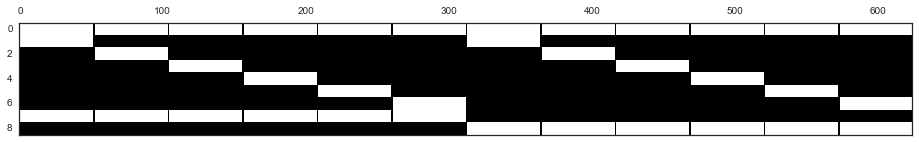

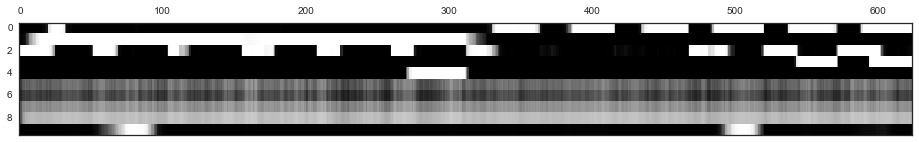

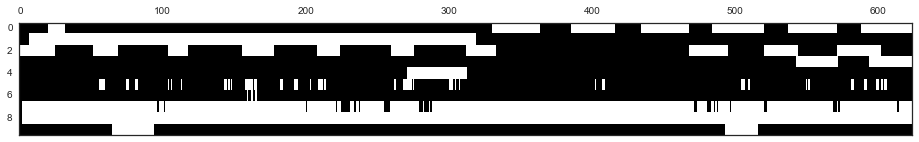

In [25]:
# plot a section in time; each row is a regressor; bottom rows are inferred categories
trng = slice(None)
matshow(edf.iloc[trng, :-K].values.T, vmin=0, vmax=1);

# zoom in on inferred
matshow(edf.iloc[trng, -K:].values.T, vmin=0, vmax=1);

# use MPM
matshow(medf.iloc[trng, -K:].values.T, vmin=0, vmax=1);

In [26]:
mmatch = (medf.T.dot(medf) + (1 - medf.T).dot(1 - medf)) / T
mmismatch = (medf.T.dot(1 - medf) + (1 - medf.T).dot(medf)) / T
moverlap = np.maximum(mmatch, mmismatch)

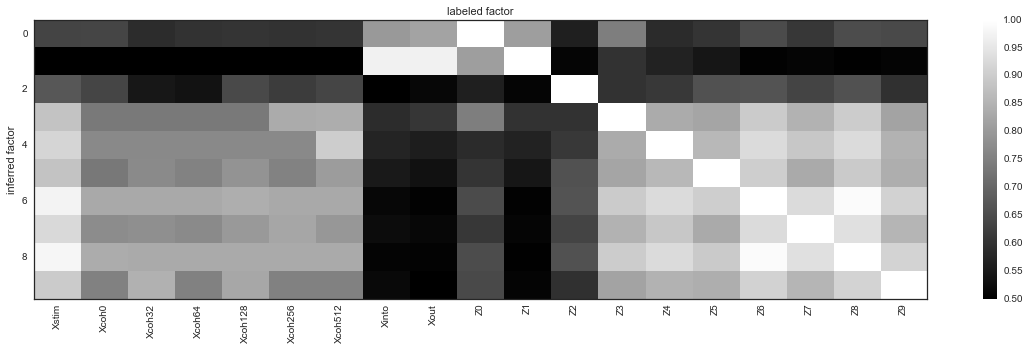

In [27]:
row_labels = medf.columns[:]
matshow(moverlap.values[-K:,:]) #, vmin=0.5, vmax=1)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');
plt.gcf().set_size_inches([20, 5])

In [28]:
moverlap.iloc[-K:, :]

,Xstim,Xcoh0,Xcoh32,Xcoh64,Xcoh128,Xcoh256,Xcoh512,Xinto,Xout,Z0,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9
Z0,0.633013,0.636218,0.588141,0.597756,0.604167,0.597756,0.604167,0.799679,0.818910,1.000000,0.809295,0.560897,0.746795,0.584936,0.602564,0.647436,0.608974,0.649038,0.642628
Z1,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.971154,0.971154,0.809295,1.000000,0.511218,0.597756,0.567308,0.543269,0.504808,0.511218,0.503205,0.509615
Z2,0.671474,0.636218,0.546474,0.536859,0.645833,0.620192,0.636218,0.501603,0.514423,0.560897,0.511218,1.000000,0.599359,0.610577,0.660256,0.663462,0.634615,0.661859,0.594551
Z3,0.883013,0.738782,0.738782,0.738782,0.738782,0.834936,0.838141,0.588141,0.607372,0.746795,0.597756,0.599359,1.000000,0.834936,0.823718,0.897436,0.849359,0.899038,0.818910
Z4,0.916667,0.769231,0.769231,0.769231,0.769231,0.769231,0.900641,0.573718,0.557692,0.584936,0.567308,0.610577,0.834936,1.000000,0.860577,0.927885,0.889423,0.929487,0.849359
Z5,0.883013,0.735577,0.770833,0.754808,0.790064,0.754808,0.806090,0.549679,0.533654,0.602564,0.543269,0.660256,0.823718,0.860577,1.000000,0.903846,0.833333,0.895833,0.841346
Z6,0.975962,0.831731,0.831731,0.831731,0.841346,0.831731,0.831731,0.514423,0.504808,0.647436,0.504808,0.663462,0.897436,0.927885,0.903846,1.000000,0.929487,0.991987,0.911859
Z7,0.924679,0.774038,0.780449,0.770833,0.799679,0.825321,0.796474,0.524038,0.514423,0.608974,0.511218,0.634615,0.849359,0.889423,0.833333,0.929487,1.000000,0.937500,0.854167
Z8,0.980769,0.836538,0.833333,0.833333,0.833333,0.833333,0.833333,0.509615,0.506410,0.649038,0.503205,0.661859,0.899038,0.929487,0.895833,0.991987,0.937500,1.000000,0.913462
Z9,0.897436,0.753205,0.846154,0.753205,0.826923,0.753205,0.753205,0.519231,0.500000,0.642628,0.509615,0.594551,0.818910,0.849359,0.841346,0.911859,0.854167,0.913462,1.000000


In [29]:
moverlap.iloc[-K:, :-K].max()

Xstim      0.980769
Xcoh0      0.836538
Xcoh32     0.846154
Xcoh64     0.833333
Xcoh128    0.841346
Xcoh256    0.834936
Xcoh512    0.900641
Xinto      0.971154
Xout       0.971154
dtype: float64